In [ ]:
!pip install fbprophet

In [1]:
import pandas as pd

import datetime
from datetime import timedelta

from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet

import time

Importing plotly failed. Interactive plots will not work.


In [2]:
path_occ = '~/Downloads/park-ride-rapperswil.csv'
path_tickets = '~/Downloads/parkrail-sale-app.csv'

In [3]:
true_occ = pd.read_csv(path_occ, sep=';')
tickets = pd.read_csv(path_tickets, sep=';')

In [4]:
start_time = time.time()

In [5]:
tickets['start'] = pd.to_datetime(tickets['start'])
tickets['end'] = pd.to_datetime(tickets['end'])

tickets['start'] = tickets['start'].apply(lambda x: x.replace(tzinfo=None))
tickets['end'] = tickets['end'].apply(lambda x: x.replace(tzinfo=None))

TOTAL_SPACE = 180

#############################################
# Tickets Processing

tickets = tickets.sort_values(by="start") 

def rounder(t):
    if t.minute >= 30:
        try:
            return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
        except ValueError:
            #return t.replace(day=t.day+1, second=0, microsecond=0, minute=0, hour=0)
            t = t.replace(second=0, microsecond=0, minute=0, hour=0)
            t = t+timedelta(hours=24)
            return t
    else:
        return t.replace(second=0, microsecond=0, minute=0)

d = {}
for row in range(len(tickets)):
    
    td = tickets.iloc[row][1] - tickets.iloc[row][0]
    hours = td.total_seconds() / 3600
    
    start = rounder(tickets.iloc[row][0])
    for hour in range(int(hours+1)):
        if start+timedelta(hours=hour) in d:
            d[start+timedelta(hours=hour)] += 1
        else:
            d[start+timedelta(hours=hour)] = 1

tickets_conv = pd.DataFrame(d.items(), columns=['date', 'occupancy_rate'])

# Occupancy dataset from ticket sales
tickets_conv['occupancy_rate'] = (tickets_conv['occupancy_rate'] / TOTAL_SPACE)*100

tickets_conv = tickets_conv.groupby("date").mean()

#############################################

#############################################
# True occupancy processing

true_occ['Datum'] = pd.to_datetime(true_occ['Datum'])

true_occ = true_occ.rename(columns={'Datum': 'date', 'BELEGUNGSQUOTE (%)': 'occupancy_rate'})

true_occ['date'] = true_occ['date'].apply(lambda x: x.replace(tzinfo=None))

true_occ = true_occ.sort_values(by="date")
true_occ = true_occ.groupby("date").mean()

#############################################



#############################################
# Add Gaussian Noise to simulate user inputs

mu, sigma = 0, 5 
# creating a noise with the same dimension as the dataset (2,2) 
noise = np.random.normal(mu, sigma, [len(true_occ),1]) 

user_input = true_occ + noise
##########################################

#############################################
# Fill missing dates

user_input = user_input.reset_index()
i = 1
while user_input.iloc[i]['date'] < user_input.iloc[-1]['date']:
    if user_input.iloc[i]['date'] != user_input.iloc[i-1]['date']+timedelta(hours=1):
        line = pd.DataFrame({"date": user_input.iloc[i-1]['date']+timedelta(hours=1),"occupancy_rate": user_input["occupancy_rate"].quantile(.25)}, index=[i])
        user_input = pd.concat([user_input.iloc[:i], line, user_input.iloc[i:]]).reset_index(drop=True)
    i+=1


tickets_conv = tickets_conv.reset_index()
i = 1
while tickets_conv.iloc[i]['date'] < tickets_conv.iloc[-1]['date']:
    if tickets_conv.iloc[i]['date'] != tickets_conv.iloc[i-1]['date']+timedelta(hours=1):
        line = pd.DataFrame({"date": tickets_conv.iloc[i-1]['date']+timedelta(hours=1),"occupancy_rate": tickets_conv.iloc[i-1]['occupancy_rate']}, index=[i])
        tickets_conv = pd.concat([tickets_conv.iloc[:i], line, tickets_conv.iloc[i:]]).reset_index(drop=True)
    i+=1

user_input = user_input.groupby("date").mean()
tickets_conv = tickets_conv.groupby("date").mean()

#############################################

#############################################
# Create training data

start = max(user_input.index[0], tickets_conv.index[0])
end = min(user_input.index[-1], tickets_conv.index[-1])

user_input_train = user_input[start:end]
tickets_train = tickets_conv[start:end]

train_data = (user_input_train*0.7)+(tickets_train*5*0.3)

#############################################

#############################################
# Create training data

train_data['occupancy_rate'] = train_data['occupancy_rate'].apply(lambda x: 0 if x < 0 else x)
#train_data['occupancy_rate'] = train_data['occupancy_rate'].apply(lambda x: 100.0 if x > 100.0 else x)

train_data_hw = train_data.iloc[:]
train_data['occupancy_rate'] = train_data['occupancy_rate'].apply(lambda x: 0.5 if x == 0 else x)

#train_hw = ExponentialSmoothing(train_data_hw['occupancy_rate'],
#                                            trend=None,seasonal='mul',seasonal_periods=24).fit()

#pred = train_hw.forecast(7*24)

model = Prophet()
model.fit(train_data_hw.reset_index().rename(columns={'date':'ds', 'occupancy_rate': 'y'}))

# Create dummy test set
ds = []
sdate = train_data_hw.index[-1]
for i in range(1,(24*7)+1):
    ds.append(sdate+timedelta(hours=i))

y = [0]*(24*7)
inp = pd.DataFrame({'ds':ds, 'y':y})

pred = model.predict(inp)

x = pred['yhat'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))

df = pd.DataFrame(x_scaled)

out = pd.DataFrame({'date':inp.ds, 'occupancy_rate':df[0]})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [6]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.683231830596924 seconds ---


## END

In [7]:
start = out.date.iloc[0]
test = true_occ[start:]

In [8]:
test['pred'] = list(out['occupancy_rate'])[:len(test)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
test['occupancy_rate'] = test['occupancy_rate']/100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='date'>

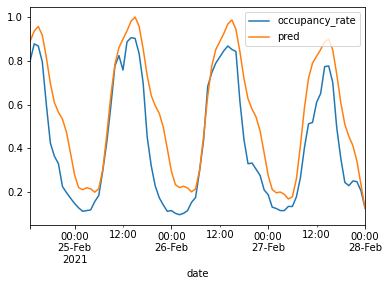

In [10]:
test.plot()

In [11]:
mean_squared_error(test['occupancy_rate'], test['pred'])

0.029521760997533404